# REINFORCE agent for Recommendations

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import time
import functools
import collections
import pandas as pd
import pickle as pkl
from pprint import pprint
from collections import defaultdict
from datetime import datetime
from typing import Callable, Dict, List, Optional, TypeVar

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tensorflow.python.platform import build_info

# tf-agents
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.metrics import export_utils
from tf_agents.policies import policy_saver
from tf_agents.trajectories import trajectory
from tf_agents.train.utils import strategy_utils
from tf_agents.policies import py_tf_eager_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.replay_buffers import tf_uniform_replay_buffer

# GPU
from numba import cuda 
import gc
from tensorflow.python.platform import build_info
print(f"cudnn version      : {build_info.build_info['cudnn_version']}")
print(f"cuda version       : {build_info.build_info['cuda_version']}")
print(f"Num GPUs Available : {len(tf.config.list_physical_devices('GPU'))}")

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

# this repo
import sys
sys.path.append("..")

from src.utils import rfa_utils as rfa_utils
from src.utils import train_utils as train_utils
from src.data import data_utils as data_utils
from src.data import data_config as data_config
from src.networks import encoding_network as emb_features

cudnn version      : 8
cuda version       : 11.8
Num GPUs Available : 1


In [6]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [7]:
print(f"device: {device.name.decode()}")

# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

device: Tesla T4


# Data utils

In [8]:
data_config.MAX_CONTEXT_LENGTH
print(f"MAX_CONTEXT_LENGTH: {data_config.MAX_CONTEXT_LENGTH}")

EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")
# !gsutil ls $GCS_DATA_PATH

MAX_CONTEXT_LENGTH: 10
GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m


## TF Example to Trajectory

In [9]:
def example_proto_to_trajectory(
    example_proto, # sequence_feature,
    sequence_length: int
):
    """
    Converts a sequence example to a Trajectory and weights for training.

    For now, we are using the following simplified features. At every point in
    time, the `context_movie_id` field in the sequence is the action and the `context_movie_id`
    at the previous time step (last action) is the observation. The `context_movie_rating` field
    is converted to a binary reward.

    If the sequence example is longer than than `sequence_length`, we only take
    the last part of the sequence example. If it is shorter, we pad it with dummy
    values at the end to equal `sequence_length`.

    Args:
    sequence_feature: A serialized SequenceExample to convert to a
      trajectory.
    sequence_length: The time dimension of the returned trajectory.

    Returns:
    trajectory: An unbatched trajectory. The time dimension will be equal to
      sequence length. The agent assumes that this trajectory is a single
      episode, so `trajectory.step_type` and `trajectory.discount` are ignored.
    weights: A [T] float tensor of weights. Each row of `weights`
        (along the time dimension) is usually a sequence of 0's, followed by
        a sequence of 1's, again followed by a sequence of 0's. This divides
        the trajectory into 3 parts. The first part is used to warm start
        the state embedding network. The second part is used to compute
        losses. Returns are computed using the second and third parts.
    """
    
    feature_description = {
        'context_movie_id': tf.io.FixedLenFeature(shape=(data_config.MAX_CONTEXT_LENGTH), dtype=tf.string),
        'context_movie_rating': tf.io.FixedLenFeature(shape=(data_config.MAX_CONTEXT_LENGTH), dtype=tf.float32),
    }
    
    sequence_feature = tf.io.parse_single_sequence_example(example_proto, feature_description)
    
    context_id_int = tf.strings.to_number(
        sequence_feature[0]['context_movie_id'],
        out_type=tf.dtypes.int64,
        name=None
    )
    
    sequence_feature[0]['context_movie_id'] = context_id_int
    actions = sequence_feature[0]['context_movie_id'][-sequence_length:]
    rewards = sequence_feature[0]['context_movie_rating'][-sequence_length:]
    observations = sequence_feature[0]['context_movie_id'][-(sequence_length+1):-1]

    # actual length
    actual_sequence_length = tf.shape(observations)[0]
    
    actions = actions[-actual_sequence_length:]
    rewards = rewards[-actual_sequence_length:]

    # padding
    paddings = tf.stack([0, sequence_length - actual_sequence_length])
    paddings = tf.expand_dims(paddings, 0)

    rewards = tf.pad(rewards, paddings, 'CONSTANT', constant_values=0)
    actions = tf.pad(actions, paddings, 'CONSTANT', constant_values=0)
    observations = tf.pad(observations, paddings, 'CONSTANT', constant_values=0)

    # steps & discounts
    discounts = tf.ones((sequence_length,), dtype=tf.float32)
    next_step_types = tf.ones(
      (sequence_length,), dtype=tf.int32) * ts.StepType.MID
    step_types = tf.concat([[ts.StepType.FIRST], next_step_types[1:]], axis=0)

    # build trajectory
    traj = trajectory.Trajectory(
        step_type=step_types,
        observation=observations,
        action=actions,
        policy_info=(),
        next_step_type=next_step_types,
        reward=rewards,
        discount=discounts
    )

    # get importance weights
    section_size = tf.cast(actual_sequence_length / 3, tf.int32)
    # print(f"section_size: {section_size}")
    
    weights = tf.concat(
        [
            tf.zeros((section_size,)),
            tf.ones((section_size,)),
            tf.zeros((sequence_length - 2 * section_size,))
        ], 
        axis=0
    )
    
    return traj, weights # sequence_feature

## Create TF Record Dataset

In [10]:
def create_single_tfrecord_ds(
    filename,
    process_example_fn,
    shuffle_buffer_size = 1,
):
    raw_ds = tf.data.TFRecordDataset(filename)
    
    ds = raw_ds.map(
        process_example_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
def create_tfrecord_ds(
    filenames,
    process_example_fn,
    batch_size: int,
    shuffle_buffer_size_per_record: int = 1,
    shuffle_buffer_size: int = 10000,
    num_shards: int = 50,
    cycle_length: int = tf.data.AUTOTUNE,
    block_length: int = 10,
    num_prefetch: int = 10,
    num_parallel_calls: int = 10,
    repeat: bool = True,
    drop_remainder: bool = False
):
    filenames = list(filenames)
    initial_len = len(filenames)
    remainder = initial_len % num_shards
    
    for _ in range(num_shards - remainder):
        filenames.append(
            filenames[np.random.randint(low=0, high=initial_len)]
        )
        
    filenames = np.array(filenames)
    np.random.shuffle(filenames)
    filenames = np.array_split(filenames, num_shards)
    filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
    
    if repeat:
        filename_ds = filename_ds.repeat()
    
    filename_ds = filename_ds.shuffle(len(filenames))
    
    example_ds = filename_ds.interleave(
        functools.partial(
            create_single_tfrecord_ds,
            process_example_fn=process_example_fn,
            shuffle_buffer_size=shuffle_buffer_size_per_record,
        ),
        cycle_length=tf.data.AUTOTUNE,
        block_length=block_length,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    example_ds = example_ds.shuffle(shuffle_buffer_size)
    
    example_ds = example_ds.batch(
        batch_size, drop_remainder=drop_remainder
    ).prefetch(num_prefetch)
  
    return example_ds

## Vocab

In [12]:
print(f"Downloading vocab...")
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

# vocab_dict['movie_id']
vocab_dict_decoded = [z.decode("utf-8") for z in vocab_dict['movie_id']]
vocab_dict_decoded.remove("UNK")
vocab_dict_decoded = tf.strings.to_number(
    vocab_dict_decoded,
    out_type=tf.dtypes.int64,
    name=None
)
vocab_dict_decoded = vocab_dict_decoded.numpy()

# update vocab_dict
vocab_dict['movie_id_int'] = vocab_dict_decoded

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



## Lookup layers

In [13]:
action_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_id_int'], 
    mask_value=None
)

inverse_action_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=action_lookup_layer.get_vocabulary(), 
    mask_value=None,
    invert=True
)

action_vocab_size = action_lookup_layer.vocab_size() # 3885

# if observations are just past actions:
observation_lookup_layer = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_id_int'], 
    mask_value=None
)

obs_vocab_size = observation_lookup_layer.vocab_size()

print(f"action_vocab_size : {action_vocab_size}")
print(f"obs_vocab_size    : {obs_vocab_size}")

action_vocab_size : 3884
obs_vocab_size    : 3884


# Agent Config

## TensorSpecs

In [14]:
global_step = tf.compat.v1.train.get_or_create_global_step()

observation_spec = tensor_spec.BoundedTensorSpec(
    shape=[],
    dtype=tf.int64, # tf.string | tf.int64,
    minimum=0,
    maximum=action_vocab_size - 1,
    name='observation'
)
time_step_spec = ts.time_step_spec(observation_spec=observation_spec)

action_spec = tensor_spec.BoundedTensorSpec(
    shape=[],
    dtype=tf.int64, # tf.string | tf.int64,
    minimum=0,
    maximum=action_vocab_size - 1,
    name='action'
)

## Network

In [15]:
input_embedding_size=100
input_fc_layer_params=(100, 100)
lstm_size=(25,)
output_fc_layer_params=(10,)

state_embedding_network = rfa_utils.create_state_embedding_network(
    observation_lookup_layer=observation_lookup_layer,
    input_embedding_size=input_embedding_size,
    input_fc_layer_units=input_fc_layer_params,
    lstm_size=lstm_size,
    output_fc_layer_units=output_fc_layer_params
)

time_step_spec.observation

BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(3883))

## Agent

In [16]:
sys.path.append("..")
from src.agents import topk_reinforce_agent as topk_reinforce_agent

from src.trainer import offline_evaluation as offline_evaluation
from src.trainer import offline_metrics as offline_metrics

In [17]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# k actions recommended by policy
policy_num_actions=5

# number of actions with highest Q value
num_greedy_actions=4

scann_num_candidate_actions=None
sampled_softmax_num_negatives=None
use_supervised_loss_for_main_policy=False
off_policy_correction_exponent=None # None | 16

GAMMA=0.5 # 0.9 | 0.5
SUMMARIZE_GRADS_AND_VARS=False
DEBUG_SUMMARIES=False # TODO: error with summary stats

distribution_strategy = strategy_utils.get_strategy(
    tpu=False, use_gpu=True
)

In [18]:
global_step = tf.compat.v1.train.get_or_create_global_step()

tf_agent = topk_reinforce_agent.TopKOffPolicyReinforceAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    state_embedding_network=state_embedding_network,
    optimizer=optimizer,
    off_policy_correction_exponent=off_policy_correction_exponent,
    action_lookup_layer=action_lookup_layer,                  # action_lookup_layer | None
    inverse_action_lookup_layer=inverse_action_lookup_layer,  # inverse_action_lookup_layer | None
    policy_num_actions=policy_num_actions,
    use_supervised_loss_for_main_policy=use_supervised_loss_for_main_policy,
    num_candidate_actions=scann_num_candidate_actions,
    num_greedy_actions=policy_num_actions,
    sampled_softmax_num_negatives=sampled_softmax_num_negatives,
    train_step_counter=global_step,
    gamma=GAMMA,
    summarize_grads_and_vars=SUMMARIZE_GRADS_AND_VARS,
    debug_summaries=DEBUG_SUMMARIES,
    name='TopKOffPolicyReinforceAgent'
)

tf_agent.initialize()

print(f"global step: {global_step.numpy()}")

global step: 0


In [19]:
state_embedding_network.summary()

# embedding = 3884 (obs vocab size) * INPUT_EMBEDDING_SIZE

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 integer_lookup_2 (IntegerL  multiple                  0         
 ookup)                                                          
                                                                 
 embedding (Embedding)       multiple                  388400    
                                                                 
 dense (Dense)               multiple                  10100     
                                                                 
 dense_1 (Dense)             multiple                  10100     
                                                                 
 dynamic_unroll (DynamicUnr  multiple                  12600     
 oll)                                                            
                                                                 
 dense_2 (Dense)             multiple                  2

In [20]:
def get_filenames(
    bucket_name,
    prefix,
    split,
):
    file_list = []
    for blob in storage_client.list_blobs(
        f"{bucket_name}", 
        prefix=f'{prefix}/{split}'
    ):
        if '.tfrecord' in blob.name:
            file_list.append(
                blob.public_url.replace(
                    "https://storage.googleapis.com/", "gs://"
                )
            )
    
    return file_list

train_files = get_filenames(
    bucket_name=BUCKET_NAME,
    prefix=EXAMPLE_GEN_GCS_PATH,
    split="train",
)
val_files = get_filenames(
    bucket_name=BUCKET_NAME,
    prefix=EXAMPLE_GEN_GCS_PATH,
    split="val",
)

print(f'num train_files : {len(train_files)}')
print(f'num val_files   : {len(val_files)}')

num train_files : 8
num val_files   : 3


In [21]:
sequence_length  = data_config.MAX_CONTEXT_LENGTH # 10

train_batch_size = 64  # 64 | 5 | 128
eval_batch_size  = 64  # 64 | 5 | 128
num_eval_batches = 50  # 10 | 1200

# tf_agent.train = common.function(tf_agent.train)
# ====================================================
# create datasets
# ====================================================
process_example_fn = functools.partial(
    example_proto_to_trajectory,
    sequence_length=sequence_length
)

train_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(train_files),
    num_shards=len(train_files),
    process_example_fn=process_example_fn,
    batch_size=train_batch_size
)
train_dataset_iterator = iter(train_dataset)

eval_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(val_files),
    process_example_fn=process_example_fn,
    batch_size=eval_batch_size,
    num_shards=len(val_files),
    repeat=False,
    drop_remainder=True
)

if num_eval_batches is not None:
    eval_dataset = eval_dataset.take(num_eval_batches)
    
print(f"eval data size: {len(list(eval_dataset))}\n")

eval data size: 50



### Eval metrics

In [23]:
evaluate = offline_evaluation.evaluate

def non_oov_filter(trajectory):
    """Returns True for non OOV actions."""
    return action_lookup_layer(trajectory.action) != 0

offline_eval_metrics = [
    offline_metrics.AccuracyAtK(),
    offline_metrics.AveragePerClassAccuracyAtK(
        action_vocab_size, action_lookup=action_lookup_layer
    ),
    offline_metrics.WeightedReturns(
        gamma=1.,
        action_lookup=action_lookup_layer,
        weight_by_probabilities=False,
        name='WeightedReturnsLogProb_gamma_1'),
    offline_metrics.WeightedReturns(
        gamma=1.,
        action_lookup=action_lookup_layer,
        weight_by_probabilities=True,
        name='WeightedReturnsProb_gamma_1'),
    # offline_metrics.LastActionAccuracyAtK(),
]

for k in [1, 5, 10]: # policy_num_actions
    offline_eval_metrics.append(
        offline_metrics.AccuracyAtK(
            trajectory_filter=non_oov_filter,
            name='AccuracyAtK_' + str(k),
            k=k
        )
    )
#     offline_eval_metrics.append(
#         offline_metrics.AveragePerClassAccuracyAtK(
#             action_vocab_size,
#             action_lookup=action_lookup_layer,
#             trajectory_filter=non_oov_filter,
#             name='AveragePerClassAccuracyAtK_' + str(k),
#             k=k)
#     )
#     offline_eval_metrics.append(
#         offline_metrics.LastActionAccuracyAtK(
#             trajectory_filter=non_oov_filter,
#             name='LastActionAccuracyAtK_' + str(k),
#             k=k)
#     )

offline_eval_metrics

## Vertex Experiments

In [24]:
EXP_VERSION="v16"

In [25]:
EXPERIMENT_NAME   = f'reinforce-local-{EXP_VERSION}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

EXPERIMENT_DIR    = os.path.join(BUCKET_URI, EXPERIMENT_NAME)
CHECKPT_DIR       = os.path.join(EXPERIMENT_DIR, "chkpoint")
BASE_OUTPUT_DIR   = os.path.join(EXPERIMENT_DIR, RUN_NAME)
LOG_DIR           = os.path.join(BASE_OUTPUT_DIR, "logs")
ROOT_DIR          = os.path.join(BASE_OUTPUT_DIR, "root")
ARTIFACTS_DIR     = os.path.join(BASE_OUTPUT_DIR, "artifacts")

TRAIN_LOG_DIR     = os.path.join(LOG_DIR, 'train')
EVAL_LOG_DIR      = os.path.join(LOG_DIR, 'eval')

print(f"EXPERIMENT_NAME : {EXPERIMENT_NAME}")
print(f"RUN_NAME        : {RUN_NAME}\n")
print(f"EXPERIMENT_DIR  : {EXPERIMENT_DIR}")
print(f"CHECKPT_DIR     : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR         : {LOG_DIR}")
print(f"ROOT_DIR        : {ROOT_DIR}")
print(f"ARTIFACTS_DIR   : {ARTIFACTS_DIR}\n")
print(f"TRAIN_LOG_DIR   : {TRAIN_LOG_DIR}")
print(f"EVAL_LOG_DIR    : {EVAL_LOG_DIR}")

EXPERIMENT_NAME : reinforce-local-v16
RUN_NAME        : run-20241211-215732

EXPERIMENT_DIR  : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16
CHECKPT_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint
BASE_OUTPUT_DIR : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732
LOG_DIR         : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/logs
ROOT_DIR        : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/root
ARTIFACTS_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts

TRAIN_LOG_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/logs/train
EVAL_LOG_DIR    : gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/logs/eval


### Checkpointer and Policy Saver

In [27]:
# check for existing checkpoint(s)...
! gsutil ls $CHECKPT_DIR

In [26]:
# `step_metric` records the number of individual rounds of bandit interaction;
# that is, (number of trajectories) * batch_size.
# step_metric = tf_metrics.EnvironmentSteps()

# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting train_checkpointer: {CHECKPT_DIR}")
train_checkpointer = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=tf_agent, 
    metrics=offline_eval_metrics, 
    step_metric=global_step
)
POLICY_CHEKPT_DIR = os.path.join(CHECKPT_DIR, 'policy')
print(f"setting policy_checkpointer: {POLICY_CHEKPT_DIR}")
policy_checkpointer = common.Checkpointer(
    ckpt_dir=POLICY_CHEKPT_DIR,
    policy=tf_agent.policy,
    global_step=global_step
)
# ====================================================
# saver
# ====================================================
topk_policy = tf_agent.policy
time_step_spec_with_time_dim = tf.nest.map_structure(
    lambda spec: policy_saver.add_batch_dim(spec, [None]),
    topk_policy.time_step_spec,
)
input_fn_and_spec = (
    lambda x: x,
    (time_step_spec_with_time_dim, topk_policy.policy_state_spec),
)
saver = policy_saver.PolicySaver(
    policy = tf_agent.policy, 
    train_step=global_step,
    input_fn_and_spec = input_fn_and_spec,
)
print(f"\nsaver signatures:")
saver.signatures

setting train_checkpointer: gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint
Did not find a pre-existing checkpoint. Starting from scratch.
setting policy_checkpointer: gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/policy

saver signatures:


{'action': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7eff3057f7f0>,
 'get_initial_state': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7eff3057c370>,
 'get_train_step': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7eff3057e470>,
 'get_metadata': <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function at 0x7eff3057c2b0>}

### summary writers

In [27]:
print(f"agent.train_step_counter: {tf_agent.train_step_counter.value().numpy()}")
print(f"global_step             : {global_step.numpy()}")

# ====================================================
# summary writers
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    TRAIN_LOG_DIR, flush_millis=10 * 1000
)
train_summary_writer.set_as_default()

eval_summary_writer = tf.compat.v2.summary.create_file_writer(
    EVAL_LOG_DIR, flush_millis=10 * 1000
)

agent.train_step_counter: 0
global_step             : 0


# Train Loop

* `tf_agent.post_process_policy()` only used with ScaNN index. see [src code](https://github.com/tottenjordan/tf_vertex_agents/blob/main/src/agents/topk_reinforce_agent.py#L340)

In [28]:
NUM_ITERATIONS   = 20_000

EVAL_INTERVAL    = int(NUM_ITERATIONS/2)
LOG_INTERVAL     = int(NUM_ITERATIONS/20)
SUMMARY_INTERVAL = 100

TRAIN_CHKPT_INTERVAL = int(NUM_ITERATIONS*4)
POLICY_CHKPT_INTERVAL= int(NUM_ITERATIONS*4)

USE_TF_FUNCTIONS = True

print(f"NUM_ITERATIONS       : {NUM_ITERATIONS}")
print(f"EVAL_INTERVAL        : {EVAL_INTERVAL}")
print(f"LOG_INTERVAL         : {LOG_INTERVAL}")
print(f"SUMMARY_INTERVAL     : {SUMMARY_INTERVAL}")
print(f"USE_TF_FUNCTIONS     : {USE_TF_FUNCTIONS}\n")
print(f"TRAIN_CHKPT_INTERVAL : {TRAIN_CHKPT_INTERVAL}")
print(f"POLICY_CHKPT_INTERVAL: {POLICY_CHKPT_INTERVAL}")

NUM_ITERATIONS       : 20000
EVAL_INTERVAL        : 10000
LOG_INTERVAL         : 1000
SUMMARY_INTERVAL     : 100
USE_TF_FUNCTIONS     : True

TRAIN_CHKPT_INTERVAL : 80000
POLICY_CHKPT_INTERVAL: 80000


In [29]:
if USE_TF_FUNCTIONS:
    tf_agent.train = common.function(tf_agent.train)

def train_step():
    trajectory, weights = next(train_dataset_iterator)
    return tf_agent.train(trajectory, weights).loss

if USE_TF_FUNCTIONS:
    train_step = common.function(train_step)

# start the timer and training
with tf.compat.v2.summary.record_if(
    lambda: tf.math.equal(global_step % SUMMARY_INTERVAL, 0)
):
    print(f"starting train loop...")
    list_o_loss=[]
    time_acc = 0
    timed_at_step = global_step.numpy()

    start_train = time.time()
    
    for i in range(NUM_ITERATIONS):
        train_loss = train_step()
        list_o_loss.append(train_loss.numpy())
        
        if global_step.numpy() % LOG_INTERVAL == 0:
            print(f'step = {global_step.numpy()}: loss = {train_loss.numpy()}')
        
        if global_step.numpy() % EVAL_INTERVAL == 0:
            # steps/sec
            time_acc += time.time() - start_train
            steps_per_sec = (global_step.numpy() - timed_at_step) / time_acc
            print(f"\n{round(steps_per_sec,3)} steps/sec")
            timed_at_step = global_step.numpy()
            time_acc = 0
            
            print(f"\nEval at step: {global_step.numpy()}...")
            # tf_agent.post_process_policy()
            evaluate(
                tf_agent.policy,
                eval_dataset,
                offline_eval_metrics=offline_eval_metrics,
                train_step=global_step,
                summary_writer=eval_summary_writer,
                summary_prefix='Metrics',
            )
            metric_utils.log_metrics(offline_eval_metrics)
            for metric in offline_eval_metrics:
                print(metric.name, ' = ', metric.result().numpy())
            
            print("="*40 + "\n")
        
        if global_step.numpy() % TRAIN_CHKPT_INTERVAL == 0:
            train_checkpointer.save(global_step)
            print(f"saved train_checkpointer step {global_step.numpy()} to {CHECKPT_DIR}")
            
        if global_step.numpy() % POLICY_CHKPT_INTERVAL == 0:
            # print(f"post processing policy...")
            # tf_agent.post_process_policy()
            policy_checkpointer.save(global_step)
            print(f"saved policy_checkpointer step {global_step.numpy()} to {POLICY_CHEKPT_DIR}")
            
runtime_mins = int((time.time() - start_train) / 60)
print(f"total runtime : {runtime_mins}")

train_checkpointer.save(global_step)
print(f"saved train_checkpointer to: {CHECKPT_DIR}")

# print(f"post processing policy...")
# tf_agent.post_process_policy()
policy_checkpointer.save(global_step)
print(f"saved policy_checkpointer to: {POLICY_CHEKPT_DIR}")

saver.save(ARTIFACTS_DIR) # options=tf.saved_model.SaveOptions(save_debug_info=True)
print(f"saved trained policy to: {ARTIFACTS_DIR}")

starting train loop...
step = 1000: loss = 46.714630126953125
step = 2000: loss = 46.480064392089844
step = 3000: loss = 46.12771224975586
step = 4000: loss = 42.37116241455078
step = 5000: loss = 40.556949615478516
step = 6000: loss = 40.574310302734375
step = 7000: loss = 45.21169662475586
step = 8000: loss = 37.84819030761719
step = 9000: loss = 42.34241485595703
step = 10000: loss = 41.61832809448242

48.145 steps/sec

Eval at step: 10000...
AccuracyAtK  =  0.086666666
AveragePerClassAccuracyAtK  =  0.03240545
WeightedReturnsLogProb_gamma_1  =  -326.8962
WeightedReturnsProb_gamma_1  =  0.27652916
AccuracyAtK_1  =  0.018645834
AccuracyAtK_5  =  0.086666666
AccuracyAtK_10  =  0.086666666

step = 11000: loss = 41.8713493347168
step = 12000: loss = 40.231956481933594
step = 13000: loss = 42.69541931152344
step = 14000: loss = 39.9033088684082
step = 15000: loss = 40.51089859008789
step = 16000: loss = 41.831642150878906
step = 17000: loss = 42.61149597167969
step = 18000: loss = 40.959

In [30]:
! gsutil ls $ARTIFACTS_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/variables/


In [31]:
! gsutil ls $CHECKPT_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/checkpoint
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/ckpt-20000.data-00000-of-00001
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/ckpt-20000.index
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/chkpoint/policy/


In [32]:
for metric in offline_eval_metrics:
    print(f"\nOffline eval metrics:")
    print(metric.name, ' = ', round(float(metric.result().numpy()), 5))


Offline eval metrics:
AccuracyAtK  =  0.09708

Offline eval metrics:
AveragePerClassAccuracyAtK  =  0.04608

Offline eval metrics:
WeightedReturnsLogProb_gamma_1  =  -309.01511

Offline eval metrics:
WeightedReturnsProb_gamma_1  =  0.40161

Offline eval metrics:
AccuracyAtK_1  =  0.02208

Offline eval metrics:
AccuracyAtK_5  =  0.09708

Offline eval metrics:
AccuracyAtK_10  =  0.09708


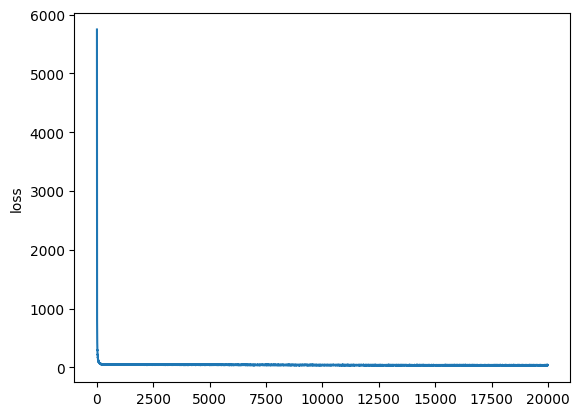

In [33]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

## TensorBoard

In [34]:
from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

In [35]:
# %load_ext tensorboard
%reload_ext tensorboard

In [37]:
# %tensorboard --logdir=$TRAIN_LOG_DIR
# %tensorboard --logdir=$EVAL_LOG_DIR
# %tensorboard --logdir=$LOG_DIR

# Serve saved policy


`input_fn_and_spec` is a tuple of (`input_fn`, `tensor_spec`)
* When `input_fn_and_spec` is set, `tensor_spec` is the input for the action signature. 
* When `input_fn_and_spec == None`, the action signature takes as input `(time_step, policy_state)`.

**TODOs**
* register functions: `saver.register_function('q_network', network, self._time_step_spec.observation)`
* specify input signature for `tf.function`: `@tf.function(input_signature=[tf.TensorSpec([], tf.float32)])`
* write eval datasets to BQ table? see docs re: [load BQ table from dataframe](https://cloud.google.com/bigquery/docs/samples/bigquery-load-table-dataframe)

In [38]:
! gsutil ls $ARTIFACTS_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/fingerprint.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/policy_specs.pbtxt
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/saved_model.pb
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/assets/
gs://rec-bandits-v2-hybrid-vertex-bucket/reinforce-local-v16/run-20241211-215732/artifacts/variables/


In [39]:
# ! gsutil ls $POLICY_CHEKPT_DIR

In [40]:
import json
import pandas as pd
from typing import Dict, List, Any

def get_slice_tensor_fn(i):
    def slice_tensor(tensor):
        return tensor[:, i, tf.newaxis]
    return slice_tensor

def _build_infer_dict(
    observed_action: int,
    pred_actions: List,
    pred_probs: List,
    sequence_id: int,
) -> Dict[str, Any]:
    
    dict_entry = {
        "sequence_id": sequence_id,
        "observed_action_id": observed_action,
        "top_k_pred_actions": pred_actions,
        "top_k_pred_probs": pred_probs,
    }
    return dict_entry

trained_policy = tf.compat.v2.saved_model.load(ARTIFACTS_DIR)
trained_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f008948e770>

### config bigquery

In [41]:
from google.cloud import bigquery

bqclient = bigquery.Client(project=PROJECT_ID)

BIGQUERY_TMP_FILE   = "tmp_infer_to_bq.json"
BQ_DATASET_ID       = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}"
BIGQUERY_TABLE_NAME = f"infer_rfa_{EXP_VERSION}"
BQ_TABLE_REF        = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_TABLE_NAME}"

tables = bqclient.list_tables(BQ_DATASET_ID)
print(f"Tables contained in {BQ_DATASET_ID}:")
for table in tables:
    print(f"{table.table_id}")
    
print(f"\nBQ_TABLE_REF {BQ_TABLE_REF}:")

Tables contained in hybrid-vertex.mvlens_rec_bandits_v2:
infer_rfa_v15
mv_b128_g12_a16
mv_b128_g12_a16_v4
mv_b128_g12_a16_v5
mv_b128_g12_a16_v6
mv_b128_g12_a16_v7
mv_b256_g12_a16_v7
mv_b256_g12_a16_v8
mv_b256_g36_a48_v9
training_dataset


In [44]:
! rm -rf $BIGQUERY_TMP_FILE

### create infer dataset

In [43]:
NUM_INFER_BATCHES = 50

inference_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(val_files),
    process_example_fn=process_example_fn,
    batch_size=1,
    num_shards=len(val_files),
    repeat=False,
    drop_remainder=True
)

if NUM_INFER_BATCHES is not None:
    inference_dataset = inference_dataset.take(NUM_INFER_BATCHES)
    
print(f"inference_dataset size: {len(list(inference_dataset))}\n")

inference_dataset size: 198834



## Write to local file

**TODOs**
* fix formatting of `< input sequence, output prediction >` pairs
* optimize this.. only utilizing ~7% of instance CPU :(

In [ ]:
dict_list = []

with open(BIGQUERY_TMP_FILE, "w") as f:
    
    for batch in inference_dataset:

        infer_trajectory, _ = batch
        policy_state = trained_policy.get_initial_state(batch_size=1)
        for i in tf.range(infer_trajectory.step_type.shape[1]): # 10
            slice_tensor = get_slice_tensor_fn(i)
            step_type = slice_tensor(infer_trajectory.step_type)    
            if step_type == ts.StepType.LAST:
                break
            observation = tf.nest.map_structure(slice_tensor, infer_trajectory.observation)
            time_step = ts.TimeStep(
                step_type=step_type,
                observation=observation,
                reward=tf.zeros_like(step_type, tf.float32),
                discount=tf.ones_like(step_type, tf.float32))

            action_step = trained_policy.action((time_step, policy_state))
            policy_state = action_step.state

            # Remove singleton batch dim.
            observed_action = tf.squeeze(slice_tensor(infer_trajectory.action), axis=0)
            predicted_action = tf.squeeze(action_step.action, axis=0)
            logits = tf.squeeze(action_step.info, axis=0)

            predicted_action_logits = tf.gather(
                logits, action_lookup_layer(predicted_action)
            )
            predicted_action_log_probs = (
                tf.math.exp(predicted_action_logits) /
                tf.math.exp(tf.reduce_logsumexp(logits))
            )
            # action_prob_list = [round(prob, 4) for prob in predicted_action_log_probs.numpy()]
            
            infer_dict = _build_infer_dict(
                sequence_id = str(i.numpy()),
                observed_action = int(observed_action.numpy()[0]),
                pred_actions = predicted_action.numpy().tolist(),
                pred_probs = predicted_action_log_probs.numpy().tolist(),
            )
            # dict_list.append(test_dict)
            f.write(json.dumps(infer_dict) + "\n")

In [46]:
infer_dict

{'sequence_id': '9',
 'observed_action_id': 0,
 'top_k_pred_actions': [0, 3045, 33, 591, 1132],
 'top_k_pred_probs': [0.05052383989095688,
  0.0380273275077343,
  0.03791634365916252,
  0.03497983515262604,
  0.028388403356075287]}

## Load BigQuery table from file

In [48]:
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("sequence_id", "INT64"),
        bigquery.SchemaField("observed_action_id", "INT64"),
        bigquery.SchemaField("top_k_pred_actions", "INT64", mode="REPEATED"),
        bigquery.SchemaField("top_k_pred_probs", "FLOAT64", mode="REPEATED"),
    ],
    source_format=bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
)

with open(BIGQUERY_TMP_FILE, "rb") as source_file:
    load_job = bqclient.load_table_from_file(
        source_file, 
        BQ_TABLE_REF, 
        job_config=job_config
    )

load_job.result()  # Wait for the job to complete.

LoadJob<project=hybrid-vertex, location=US, id=bca78b29-19b0-4715-bdbb-f904d4e4554e>

### check BigQuery table

In [214]:
query = f"""
    SELECT * 
    FROM `{BQ_TABLE_REF}`
    LIMIT 5
"""
bqclient.query(query).to_dataframe()

,sequence_id,observed_action_id,top_k_pred_actions,top_k_pred_probs
0,0,1272,"[1245, 1854, 1816, 344, 2326]","[0.014563368633389473, 0.012623777613043785, 0..."
1,0,2044,"[1908, 1917, 2884, 2310, 1907]","[0.005249397829174995, 0.00501882191747427, 0...."
2,0,3633,"[1178, 2502, 1220, 1196, 537]","[0.05298368260264397, 0.03260182589292526, 0.0..."
3,0,2645,"[1372, 1726, 148, 1245, 505]","[0.002528125885874033, 0.002159023191779852, 0..."
4,0,2330,"[1245, 174, 1287, 3292, 2220]","[0.009872911497950554, 0.007305745035409927, 0..."


### tmp - original agent eval works

In [44]:
eval_metric_results = evaluate(
    policy=tf_agent.policy,
    dataset=eval_dataset,
    offline_eval_metrics=offline_eval_metrics,
    train_step=global_step,
    summary_writer=eval_summary_writer,
    summary_prefix='Metrics',
)
metric_utils.log_metrics(offline_eval_metrics)
for metric in offline_eval_metrics:
    print(f"{metric.name} = {metric.result().numpy()}")

AccuracyAtK  =  0.08798958
AveragePerClassAccuracyAtK  =  0.033557743
WeightedReturns_gamma_1  =  -311.1016


In [45]:
eval_metric_results

OrderedDict([('AccuracyAtK',
              <tf.Tensor: shape=(), dtype=float32, numpy=0.08798958>),
             ('AveragePerClassAccuracyAtK',
              <tf.Tensor: shape=(), dtype=float32, numpy=0.033557743>),
             ('WeightedReturns_gamma_1',
              <tf.Tensor: shape=(), dtype=float32, numpy=-311.1016>)])

# Inference

In [38]:
inference_dataset = create_tfrecord_ds(
    tf.io.gfile.glob(val_files),
    process_example_fn=process_example_fn,
    batch_size=1,
    num_shards=len(val_files),
    repeat=False,
    drop_remainder=True
)
infer_batch = list(inference_dataset.take(1))[0]
traj_infer, weights_infer = infer_batch

traj_infer

Trajectory(
{'action': <tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[1575, 1189,  257, 1373, 1222, 1179,  293, 1959, 2255,    0]])>,
 'discount': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[1178, 1575, 1189,  257, 1373, 1222, 1179,  293, 1959,    0]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[4., 4., 5., 3., 4., 5., 4., 4., 4., 0.]], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>})

In [39]:
policy_state = tf_agent.policy.get_initial_state(traj_infer.step_type.shape[0])
policy_state

((ListWrapper([<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>]),),)

In [52]:
traj_infer.step_type.shape[1]

10

In [53]:
predicted_actions = []
predicted_info = []

for i in tf.range(traj_infer.step_type.shape[1]):

    observation = traj_infer.observation[:, i, tf.newaxis]
    step_type = traj_infer.step_type[:, i, tf.newaxis]
    time_step = ts.TimeStep(
        step_type=step_type,
        observation=observation,
        reward=tf.zeros_like(step_type, tf.float32),
        discount=tf.ones_like(step_type, tf.float32)
    )

    action_step = tf_agent.policy.action(time_step, policy_state)
    policy_state = action_step.state
    predicted_actions.append(action_step.action)
    predicted_info.append(action_step.info)

In [54]:
predicted_actions

[<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[2286, 2327, 2693, 2643, 2890]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604,  293,  589, 1203, 1178]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 740,  537, 1203, 1176, 1201]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604, 1203,  589,  293, 1575]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604, 1203, 1575,  589,  523]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604, 1575, 1203,  523, 1176]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604, 1575, 1203,  523,  293]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604, 1203, 1575, 1186,  896]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 604,  293, 1203, 1073, 1227]])>,
 <tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[1239, 2327,    0, 3045,  604]])>]

In [56]:
from tf_agents.trajectories import policy_step

predicted_policy_steps = policy_step.PolicyStep(
    action=tf.stack(predicted_actions, axis=1),
    info=tf.stack(predicted_info, axis=1),
    state=(),
)
# predicted_policy_steps

In [57]:
action_step.state

((ListWrapper([<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[-0.9924962 , -0.43294802, -0.13293791, -0.98814684, -0.95580554,
          -0.75280285, -0.3342112 ,  0.04315013, -0.22813249, -0.48958498,
           0.36431283, -0.05004348,  0.269563  ,  0.80608946, -0.75890887,
           0.88578224,  0.5588108 ,  0.9820511 , -0.9309011 ,  0.25365648,
           0.15573905, -0.25155395, -0.6851974 ,  0.58167934, -0.9428432 ]],
        dtype=float32)>, <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
  array([[-3.8534534 , -0.58873487, -0.13497807, -3.422552  , -1.930584  ,
          -0.9811599 , -0.34769666,  0.0431806 , -0.23406102, -0.5355571 ,
           0.38509816, -0.0511927 ,  0.27639252,  1.1330612 , -1.0014565 ,
           1.402878  ,  0.6784168 ,  2.3521845 , -1.6693163 ,  0.26190168,
           0.15705466, -0.2570712 , -0.8388488 ,  0.9551589 , -1.8594316 ]],
        dtype=float32)>]),),)

In [58]:
observed_actions = tf.expand_dims(traj_infer.action, axis=2)
observed_actions

<tf.Tensor: shape=(1, 10, 1), dtype=int64, numpy=
array([[[1230],
        [ 740],
        [2937],
        [1203],
        [ 911],
        [1284],
        [ 907],
        [  33],
        [ 220],
        [   0]]])>

In [59]:
predicted_actions_stacked = tf.stack(predicted_actions, axis=1)
predicted_actions_stacked

<tf.Tensor: shape=(1, 10, 5), dtype=int64, numpy=
array([[[2286, 2327, 2693, 2643, 2890],
        [ 604,  293,  589, 1203, 1178],
        [ 740,  537, 1203, 1176, 1201],
        [ 604, 1203,  589,  293, 1575],
        [ 604, 1203, 1575,  589,  523],
        [ 604, 1575, 1203,  523, 1176],
        [ 604, 1575, 1203,  523,  293],
        [ 604, 1203, 1575, 1186,  896],
        [ 604,  293, 1203, 1073, 1227],
        [1239, 2327,    0, 3045,  604]]])>

In [60]:
correct_predictions = tf.reduce_any(
    predicted_actions_stacked == observed_actions, axis=2
)
correct_predictions

<tf.Tensor: shape=(1, 10), dtype=bool, numpy=
array([[False, False, False,  True, False, False, False, False, False,
         True]])>

In [61]:
print('Correct Predictions:')
print(correct_predictions)
print('-' * 80)

Correct Predictions:
tf.Tensor([[False False False  True False False False False False  True]], shape=(1, 10), dtype=bool)
--------------------------------------------------------------------------------


In [62]:
print('Observed Actions (vocab):')
print(action_lookup_layer(traj_infer.action))

Observed Actions (vocab):
tf.Tensor([[1231  741 2938 1204  912 1285  908   34  221    1]], shape=(1, 10), dtype=int64)


In [63]:
print('Predicted Actions (vocab):')
print(action_lookup_layer(predicted_actions))
print('-' * 80)

Predicted Actions (vocab):
tf.Tensor(
[[[2287 2328 2694 2644 2891]]

 [[ 605  294  590 1204 1179]]

 [[ 741  538 1204 1177 1202]]

 [[ 605 1204  590  294 1576]]

 [[ 605 1204 1576  590  524]]

 [[ 605 1576 1204  524 1177]]

 [[ 605 1576 1204  524  294]]

 [[ 605 1204 1576 1187  897]]

 [[ 605  294 1204 1074 1228]]

 [[1240 2328    1 3046  605]]], shape=(10, 1, 5), dtype=int64)
--------------------------------------------------------------------------------
